In [1]:
#!/usr/bin/env python
#
# Simple DMRG tutorial.  This code contains a basic implementation of the
# infinite system algorithm
#
# Copyright 2013 James R. Garrison and Ryan V. Mishmash.
# Open source under the MIT license.  Source code at
# <https://github.com/simple-dmrg/simple-dmrg/>

# This code will run under any version of Python >= 2.6.  The following line
# provides consistency between python2 and python3.
from __future__ import print_function, division  # requires Python >= 2.6

# numpy and scipy imports
import time
import numpy as np
from IPython.display import display, clear_output
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh  # Lanczos routine from ARPACK
import matplotlib.pyplot as plt
# We will use python's "namedtuple" to represent the Block and EnlargedBlock
# objects
from collections import namedtuple
start_time = time.time()
Block = namedtuple("Block", ["length", "basis_size", "operator_dict"])
EnlargedBlock = namedtuple("EnlargedBlock", ["length", "basis_size", "operator_dict"])

def is_valid_block(block):
    for op in block.operator_dict.values():
        if op.shape[0] != block.basis_size or op.shape[1] != block.basis_size:
            return False
    return True

# This function should test the same exact things, so there is no need to
# repeat its definition.
is_valid_enlarged_block = is_valid_block

# Model-specific code for the Heisenberg XXZ chain
# Model-specific code for the Heisenberg XXZ chain
model_d = 3  # single-site basis size

Sz1 = np.array([[-1, 0,0], [0, 0,0], [0,0,1]], dtype='d')  # single-site S^z
Sp1 = np.array([[0, 0, 0], [np.sqrt(2), 0, 0], [0, np.sqrt(2), 0]], dtype='d')  # single-site S^+

H1 = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]], dtype='d')  # single-site portion of H is zero

def H2(Sz1, Sp1, Sz2, Sp2):  # two-site part of H
    """Given the operators S^z and S^+ on two sites in different Hilbert spaces
    (e.g. two blocks), returns a Kronecker product representing the
    corresponding two-site term in the Hamiltonian that joins the two sites.
    """
    J = 0.2
    Jz = 1.
    return (
        (J / 2) * (kron(Sp1, Sp2.conjugate().transpose()) + kron(Sp1.conjugate().transpose(), Sp2)) +
        Jz * kron(Sz1, Sz2)
    )

# conn refers to the connection operator, that is, the operator on the edge of
# the block, on the interior of the chain.  We need to be able to represent S^z
# and S^+ on that site in the current basis in order to grow the chain.
initial_block = Block(length=1, basis_size=model_d, operator_dict={
    "H": H1,
    "conn_Sz": Sz1,
    "conn_Sp": Sp1,
})

def enlarge_block(block):
    """This function enlarges the provided Block by a single site, returning an
    EnlargedBlock.
    """
    mblock = block.basis_size
    o = block.operator_dict

    # Create the new operators for the enlarged block.  Our basis becomes a
    # Kronecker product of the Block basis and the single-site basis.  NOTE:
    # `kron` uses the tensor product convention making blocks of the second
    # array scaled by the first.  As such, we adopt this convention for
    # Kronecker products throughout the code.
    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(length=(block.length + 1),
                         basis_size=(block.basis_size * model_d),
                         operator_dict=enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    """Transforms the operator to the new (possibly truncated) basis given by
    `transformation_matrix`.
    """
    return transformation_matrix.conjugate().transpose().dot(operator.dot(transformation_matrix))

def single_dmrg_step(sys, env, m):
    """Performs a single DMRG step using `sys` as the system and `env` as the
    environment, keeping a maximum of `m` states in the new basis.
    """
    assert is_valid_block(sys)
    assert is_valid_block(env)

    # Enlarge each block by a single site.
    sys_enl = enlarge_block(sys)
    if sys is env:  # no need to recalculate a second time
        env_enl = sys_enl
    else:
        env_enl = enlarge_block(env)

    assert is_valid_enlarged_block(sys_enl)
    assert is_valid_enlarged_block(env_enl)

    # Construct the full superblock Hamiltonian.
    m_sys_enl = sys_enl.basis_size
    m_env_enl = env_enl.basis_size
    sys_enl_op = sys_enl.operator_dict
    env_enl_op = env_enl.operator_dict
    superblock_hamiltonian = kron(sys_enl_op["H"], identity(m_env_enl)) + kron(identity(m_sys_enl), env_enl_op["H"]) + \
                             H2(sys_enl_op["conn_Sz"], sys_enl_op["conn_Sp"], env_enl_op["conn_Sz"], env_enl_op["conn_Sp"])

    # Call ARPACK to find the superblock ground state.  ("SA" means find the
    # "smallest in amplitude" eigenvalue.)
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")

    # Construct the reduced density matrix of the system by tracing out the
    # environment
    #
    # We want to make the (sys, env) indices correspond to (row, column) of a
    # matrix, respectively.  Since the environment (column) index updates most
    # quickly in our Kronecker product structure, psi0 is thus row-major ("C
    # style").
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    rho = np.dot(psi0, psi0.conjugate().transpose())

    # Diagonalize the reduced density matrix and sort the eigenvectors by
    # eigenvalue.
    evals, evecs = np.linalg.eigh(rho)
    possible_eigenstates = []
    for eval, evec in zip(evals, evecs.transpose()):
        possible_eigenstates.append((eval, evec))
    possible_eigenstates.sort(reverse=True, key=lambda x: x[0])  # largest eigenvalue first

    # Build the transformation matrix from the `m` overall most significant
    # eigenvectors.
    my_m = min(len(possible_eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (eval, evec) in enumerate(possible_eigenstates[:my_m]):
        transformation_matrix[:, i] = evec

    truncation_error = 1 - sum([x[0] for x in possible_eigenstates[:my_m]])
    #print("truncation error:", truncation_error)

    # Rotate and truncate each operator.
    new_operator_dict = {}
    for name, op in sys_enl.operator_dict.items():
        new_operator_dict[name] = rotate_and_truncate(op, transformation_matrix)

    newblock = Block(length=sys_enl.length,
                     basis_size=my_m,
                     operator_dict=new_operator_dict)

    return newblock, energy

m = 10 Last energy per site: -1.0114018777815441
m = 12 Last energy per site: -1.0114021750707924
m = 14 Last energy per site: -1.011402171731165
m = 16 Last energy per site: -1.0114021802522233
m = 18 Last energy per site: -1.0114021826846173
m = 20 Last energy per site: -1.0114021827002602
m = 22 Last energy per site: -1.0114021827127249
m = 24 Last energy per site: -1.0114021827166257
m = 26 Last energy per site: -1.0114021827173387
m = 28 Last energy per site: -1.0114021827185267
m = 30 Last energy per site: -1.0114021827187252
m = 32 Last energy per site: -1.0114021827178785
m = 34 Last energy per site: -1.0114021827182922
m = 36 Last energy per site: -1.0114021827187987
m = 38 Last energy per site: -1.011402182718803
m = 40 Last energy per site: -1.0114021827188162
m = 42 Last energy per site: -1.0114021827188087
m = 44 Last energy per site: -1.0114021827185158
m = 46 Last energy per site: -1.0114021827188133
m = 48 Last energy per site: -1.0114021827188335
m = 50 Last energy per

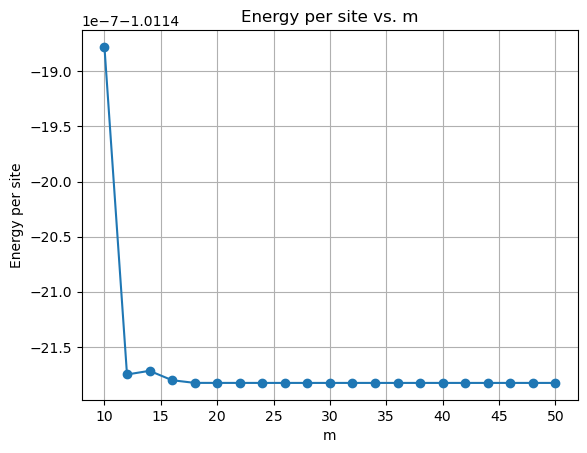


Execution time:  1.7783e+03 seconds


In [2]:
def infinite_system_algorithm(L, m):
    block = initial_block
    last_energy = None  # Variable to store the last energy per site

    while 2 * block.length < L:
        block, energy = single_dmrg_step(block, block, m=m)
        last_energy = energy / (block.length * 2)  # Update the last energy per site
        
    print("m =", m, "Last energy per site:", last_energy)
    return last_energy

if __name__ == "__main__":
    np.set_printoptions(precision=10, suppress=True, threshold=10000, linewidth=300)

    energy_per_site_list = []  # List to store energy per site for each value of m
    m_values = np.arange(10, 52, 2)
    
    for m in m_values:
        while True:  # Infinite loop
            initial_block = Block(length=1, basis_size=model_d, operator_dict={
                "H": H1,
                "conn_Sz": Sz1,
                "conn_Sp": Sp1,
            })  # Initialize the initial block for each m
            energy = infinite_system_algorithm(L=500, m=m)
            energy_per_site_list.append(energy)  # Append the last energy per site for the current m
            break  # Exit the loop and move to the next value of m

    print("Energy per site list:", energy_per_site_list)
    
    plt.plot(m_values, energy_per_site_list, marker='o', linestyle='-')
    plt.xlabel('m')
    plt.ylabel('Energy per site')
    plt.title('Energy per site vs. m')
    plt.grid(True)
    plt.savefig('DMRG_Fin.png')
    plt.show()
    
      # End time measurement
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nExecution time: {execution_time: .4e} seconds")


